### Training Naïve Bayes

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### Recovering the data

In [132]:
X_train = pd.read_csv("../datasets/okx_datasets/X_train.csv")
X_test  = pd.read_csv("../datasets/okx_datasets/X_test.csv")
y_train = pd.read_csv("../datasets/okx_datasets/y_train.csv").values.ravel()
y_test  = pd.read_csv("../datasets/okx_datasets/y_test.csv").values.ravel()

In [133]:
print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (180, 192)
X_test: (46, 192)
y_train: (180,)
y_test: (46,)


#### Training the NB with all variables

In [134]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [135]:
nb = GaussianNB()

In [136]:
param_grid = {
    "var_smoothing": np.logspace(-12, -6, 20)
}

In [137]:
# applying hyperparameter selection with Grid Search
grid = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

In [138]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e-12, 2.06913808e-12, 4.28133240e-12, 8.85866790e-12,
       1.83298071e-11, 3.79269019e-11, 7.84759970e-11, 1.62377674e-10,
       3.35981829e-10, 6.95192796e-10, 1.43844989e-09, 2.97635144e-09,
       6.15848211e-09, 1.27427499e-08, 2.63665090e-08, 5.45559478e-08,
       1.12883789e-07, 2.33572147e-07, 4.83293024e-07, 1.00000000e-06])},
             scoring='accuracy')

In [139]:
print("Melhores hiperparâmetros encontrados:")
print(grid.best_params_)
print("\nMelhor score de validação:", grid.best_score_)

Melhores hiperparâmetros encontrados:
{'var_smoothing': 4.832930238571752e-07}

Melhor score de validação: 0.3611111111111111


In [140]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

##### Results of the model with all the features

In [141]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns

In [142]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

In [143]:
print("\n==================== MÉTRICAS ====================")
print(f"Acurácia:  {acc:.4f}")
print(f"Precisão:  {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")


==================== MÉTRICAS ====================
Acurácia:  0.4130
Precisão:  0.5719
Recall:    0.4130
F1-score:  0.4484


In [144]:
print("\n==================== CLASSIFICATION REPORT ====================")
print(classification_report(y_test, y_pred, zero_division=0))


==================== CLASSIFICATION REPORT ====================
              precision    recall  f1-score   support

           0       0.18      0.57      0.28         7
           1       0.71      0.40      0.51        30
           2       0.43      0.33      0.38         9

    accuracy                           0.41        46
   macro avg       0.44      0.43      0.39        46
weighted avg       0.57      0.41      0.45        46



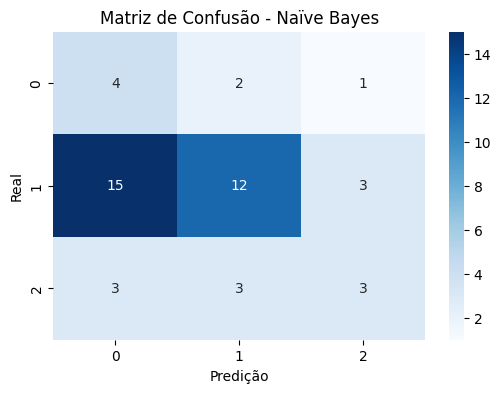

In [145]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Naïve Bayes")
plt.xlabel("Predição")
plt.ylabel("Real")
plt.show()

#### Training the NB with the K selected variables

In [146]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

In [147]:
feature_names = X_train.columns.tolist()
n_features = X_train.shape[1]
k_values = list(range(1, n_features + 1))

In [148]:
pipe = Pipeline([
    ("select", SelectKBest(score_func=f_classif)),
    ("nb", GaussianNB())
])

In [149]:
param_grid = {
    "select__k": k_values
}

In [150]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    return_train_score=False,
    n_jobs=-1
)

In [151]:
grid.fit(X_train, y_train)
results = grid.cv_results_

print("\n Melhor combinação encontrada:")
print(grid.best_params_)

best_k = grid.best_params_["select__k"]
print(f"\n Melhor K encontrado: {best_k}")


 Melhor combinação encontrada:
{'select__k': 1}

 Melhor K encontrado: 1


In [152]:
best_selector = grid.best_estimator_.named_steps["select"]
mask = best_selector.get_support()
selected_features = X_train.columns[mask].tolist()

print("\n Features selecionadas:")
for f in selected_features:
    print(" -", f)


 Features selecionadas:
 - T-score Value


In [153]:
X_train_sel = best_selector.transform(X_train)
X_test_sel  = best_selector.transform(X_test)

In [154]:
best_nb = grid.best_estimator_.named_steps["nb"]
best_nb.fit(X_train_sel, y_train)

GaussianNB()

In [155]:
y_pred = best_nb.predict(X_test_sel)

##### Results of the model with the selected features

In [156]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

In [157]:
print("\n==================== MÉTRICAS MODELO FINAL ====================")
print(f"Acurácia:   {acc:.4f}")
print(f"Precisão:   {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1-score:   {f1:.4f}")


==================== MÉTRICAS MODELO FINAL ====================
Acurácia:   0.9783
Precisão:   0.9790
Recall:     0.9783
F1-score:   0.9776


In [158]:
print("\n==================== CLASSIFICATION REPORT ====================")
print(classification_report(y_test, y_pred, zero_division=0))


==================== CLASSIFICATION REPORT ====================
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.97      1.00      0.98        30
           2       1.00      1.00      1.00         9

    accuracy                           0.98        46
   macro avg       0.99      0.95      0.97        46
weighted avg       0.98      0.98      0.98        46



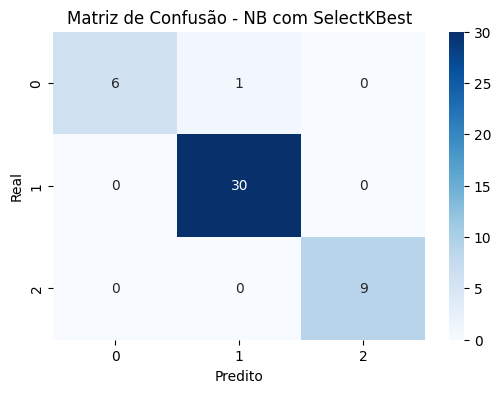

In [159]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - NB com SelectKBest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [164]:
from sklearn.model_selection import learning_curve

In [165]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_nb,
    X=X_train_sel,
    y=y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

In [166]:
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

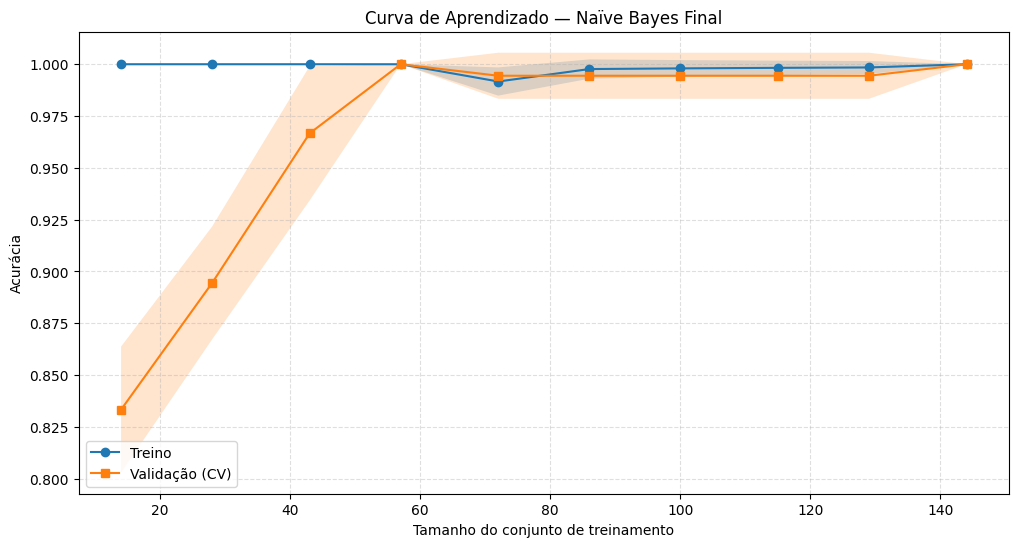

In [167]:
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_mean, marker="o", label="Treino")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, marker="s", label="Validação (CV)")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Curva de Aprendizado — Naïve Bayes Final")
plt.xlabel("Tamanho do conjunto de treinamento")
plt.ylabel("Acurácia")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()